https://www.youtube.com/watch?v=VMj-3S1tku0

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
# import torch
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

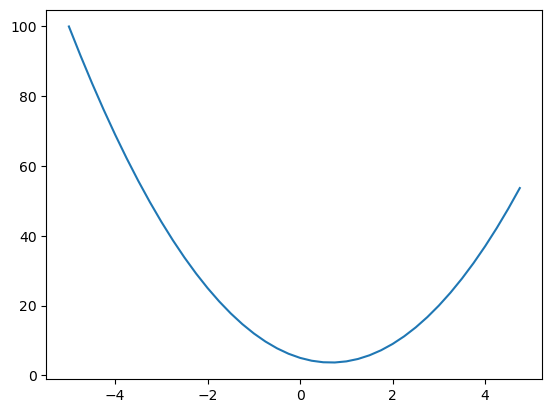

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x+h) - f(x)) / h # gives the slope of the tangent line at x

2.999378523327323e-06

In [6]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
# checking derivate of d with respect to a, b, c
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h # the slope of d with respect to b (gives a as slope)
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1) / h)

d1: 4.0
d2: 4.00002
slope: 2.0000000000131024


In [8]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children) # set of children, used for backpropagation
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # gradient of self is 1 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out # feed self and other as children (gets stored in _prev)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # gradient of self is other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward(): # chain rule
            self.grad += (other * self.data**(other-1)) * out.grad # gradient of self is (other * self.data**(other-1)) * out.grad because d/dx x^n = n*x^(n-1)
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad # gradient of self is (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward(): # chain rule
            self.grad += math.exp(x) * out.grad # gradient of self is math.exp(x) * out.grad because d/dx e^x = e^x
        out._backward = _backward

        return out
    
    def backward(self): # backpropagate gradients
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1 # grad of final node is 1
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L' # the output of the network (the loss function)
d

Value(data=4.0)

In [9]:
a = Value(2.0, label='a')
b = Value(4.0)
a-b

Value(data=-2.0)

In [10]:
import networkx as nx
import matplotlib.animation as animation
from networkx.drawing.nx_agraph import graphviz_layout


def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_graph(root):
  G = nx.DiGraph()
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    label = n.label if hasattr(n, 'label') else 'No Label'
    G.add_node(uid, label = "{ %s | data %.4f | grad %.4f }" % (label, n.data, n.grad))
    if n._op:
      G.add_node(uid + n._op, label = n._op)
      G.add_edge(uid + n._op, uid)

  for n1, n2 in edges:
    G.add_edge(str(id(n1)), str(id(n2)) + n2._op)

  # Use pygraphviz to create a left-to-right layout
  A = nx.nx_agraph.to_agraph(G)
  A.layout(prog='dot', args='-Grankdir=LR')
  pos = graphviz_layout(G, prog='dot')

  labels = nx.get_node_attributes(G, 'label')

  plt.figure(figsize=(12, 12))  # You can adjust the size as needed
  nx.draw(G, pos, labels=labels, with_labels=True, node_size=500, arrowsize=10, arrowstyle='->')
  plt.show()

In [11]:
from IPython.display import Image, HTML
import pygraphviz as pgv

def draw_graphviz(root):
  A = pgv.AGraph(directed=True, rankdir='LR')

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    label = n.label if hasattr(n, 'label') else 'No Label'
    A.add_node(uid, label="{ %s | data %.4f | grad %.4f }" % (label, n.data, n.grad))
    if n._op:
      A.add_node(uid + n._op, label=n._op)
      A.add_edge(uid + n._op, uid)

  for n1, n2 in edges:
    A.add_edge(str(id(n1)), str(id(n2)) + n2._op)

  A.layout(prog='dot')
  A.draw('graph.png')
  return Image('graph.png')

L = d * f

dL/dd = f (this is the derivative of L with respect to d, it is f because f is the only term that depends on d and the derivative of d is 1)

(f(x+h) - f(x))/h  (this is the definition of the derivative)

((d+h)*f - d*f)/h (this is the derivative of L with respect to d)

(d*f + h*f - d*f)/h (simplify)

(h*f)/h (cancel out the d*f)

f (simplify)

dL / dc (we need to know how L changes with respect to c) (we can use the chain rule)

d = c + e

(f(x+h) - f(x))/h (this is the definition of the derivative)

((c+h + e) - (c + e))/h

(c + h + e - c - e) / h

(h) / h

1

dd / dc = 1 (this is the derivative of d with respect to c)
dd / de = 1 (this is the derivative of d with respect to e)
d = c + e

WANT:
dL / dc = (dL / dd) * (dd / dc) (this is the chain rule!)

KNOW:
dL / dd = f = -2
dd / dc = 1

dL / de = -2

e = a * b

de / da? = b = -3.0

dL / da = (dL/de) * (de/da) (this is the chain rule!)

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b (the neuron activation function)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

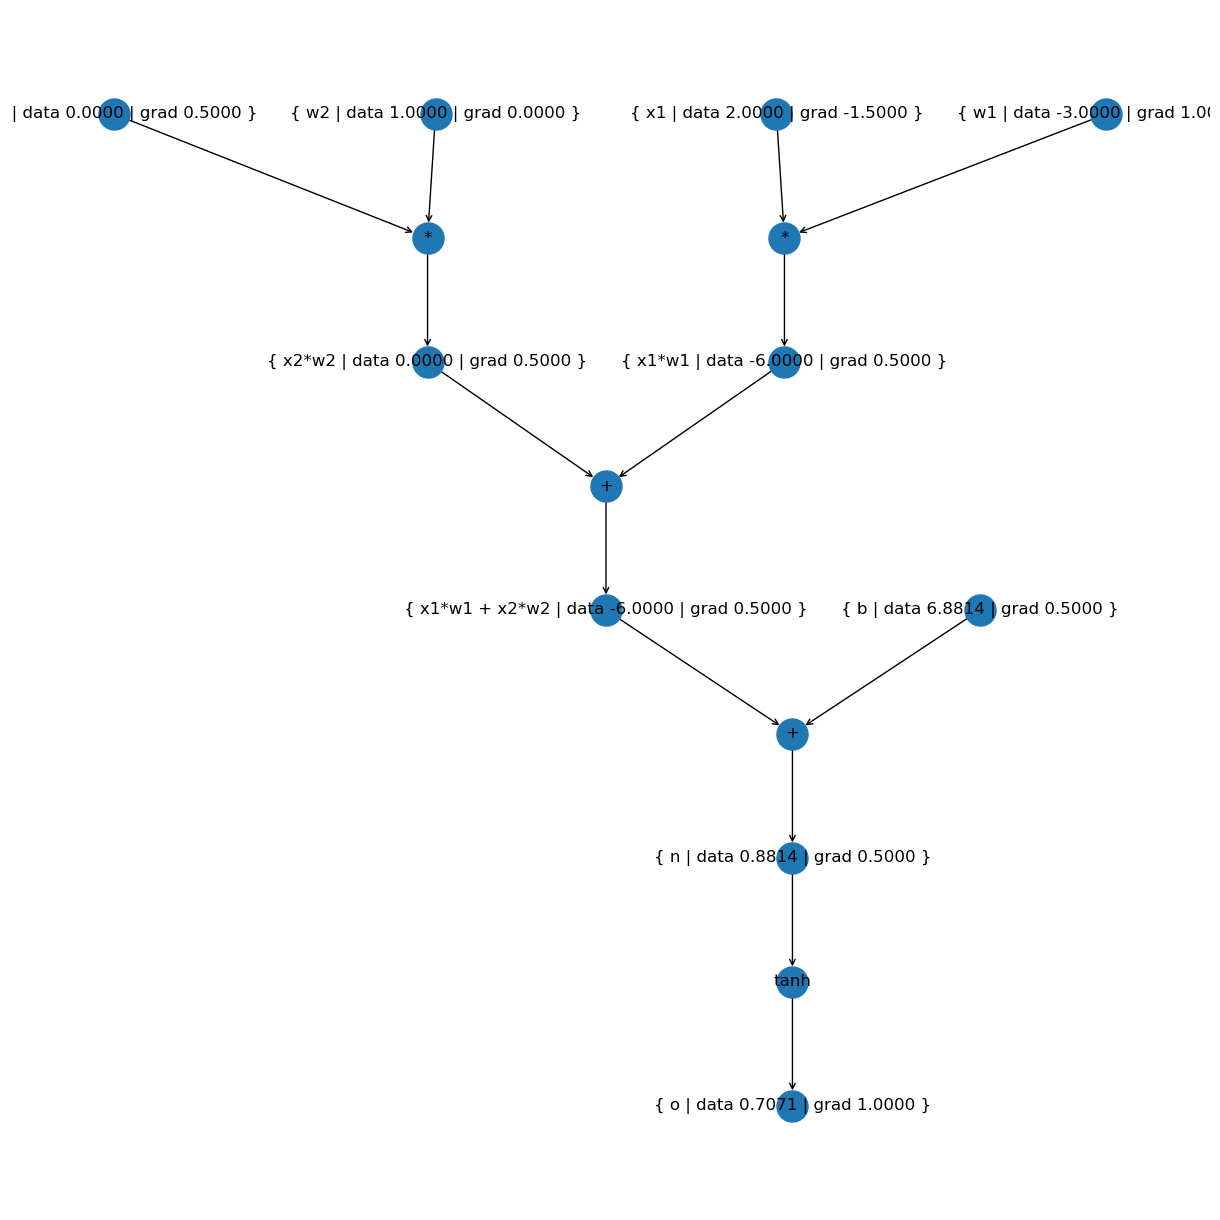

In [13]:
o.backward()
draw_graph(o)

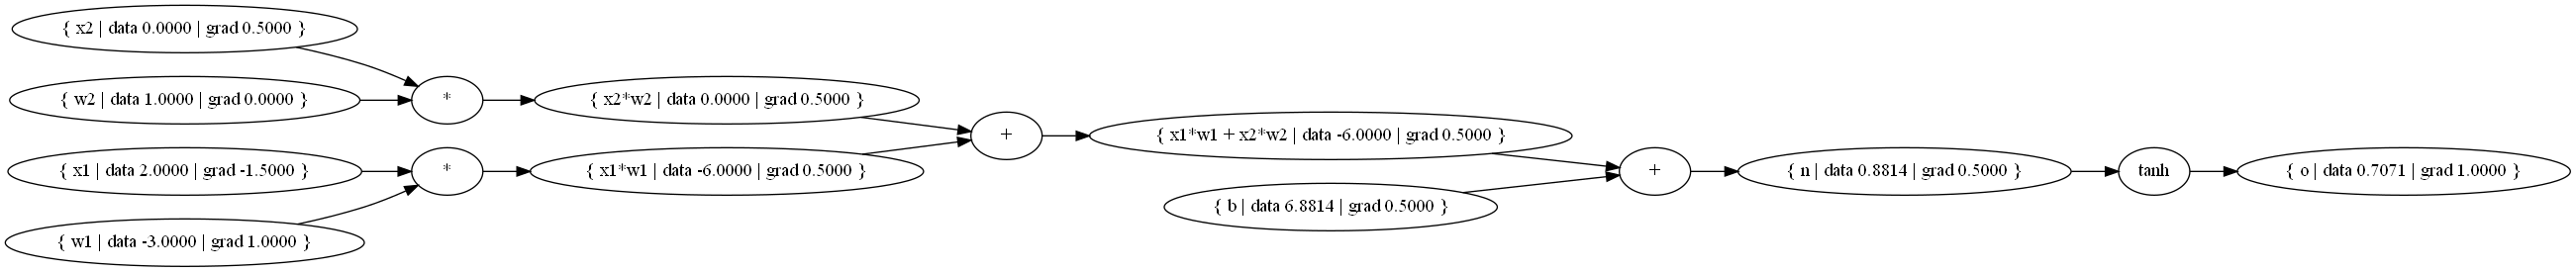

In [14]:
draw_graphviz(o)

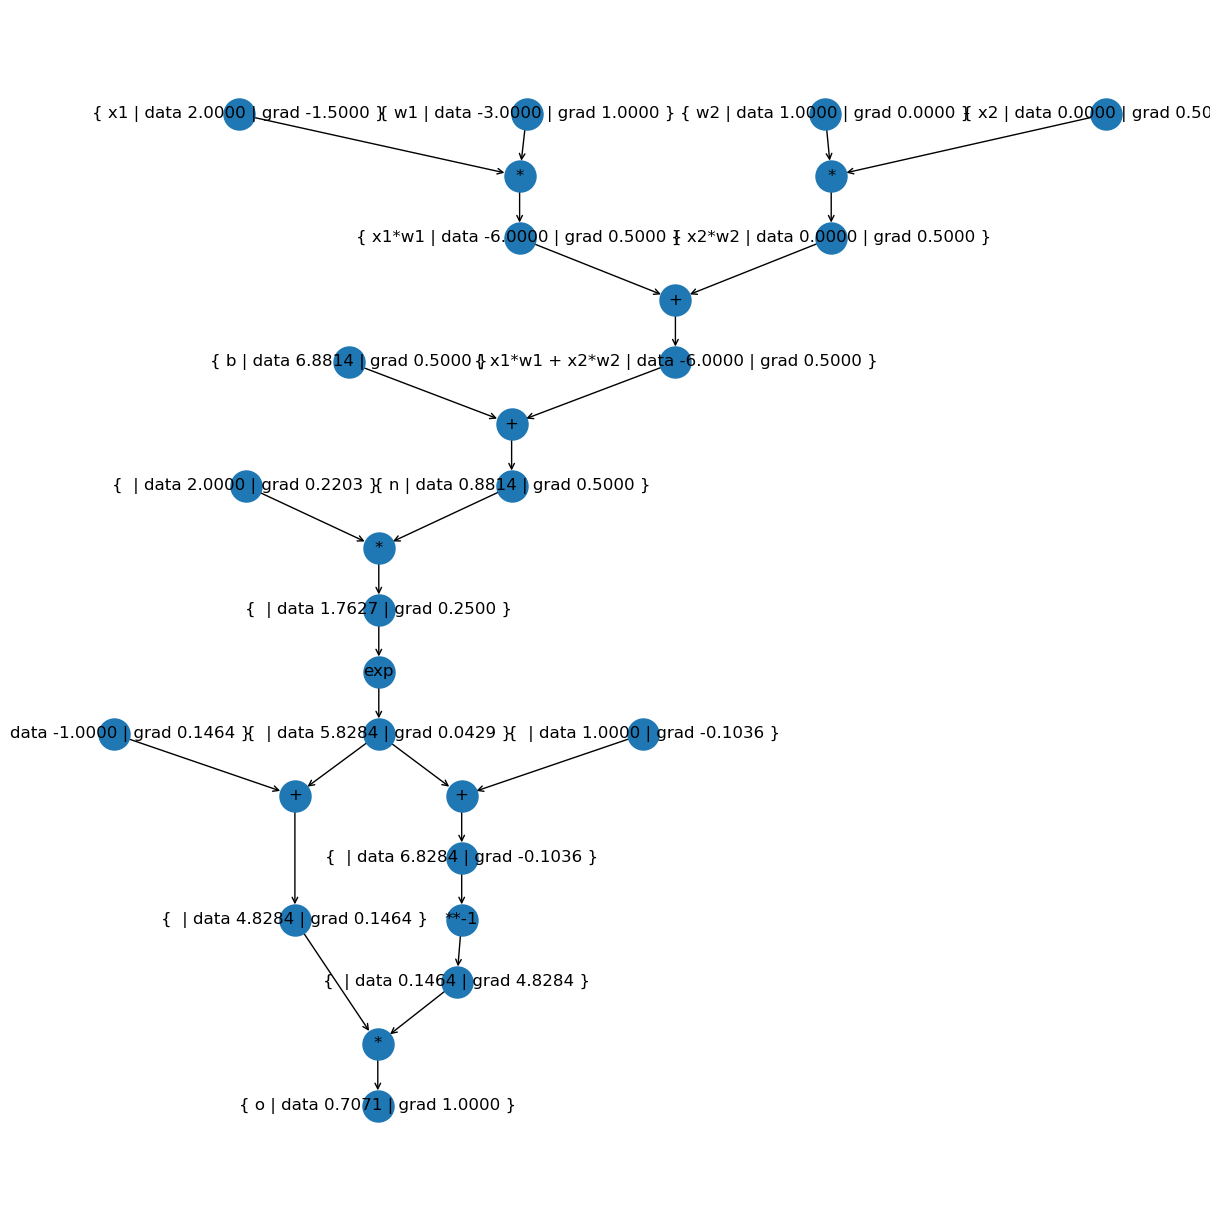

In [15]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b (the neuron activation function)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'
o.backward()
draw_graph(o)

In [16]:
# # pytorch version
# x1 = torch.tensor([2.0]).double(); x1.requires_grad = True # requires_grad tells pytorch to track gradients for this tensor, casting to double for more precision
# x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
# w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
# w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
# b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
# n = x1*w1 + x2*w2 + b
# o = torch.tanh(n)

# print(o.data.item())
# o.backward()

# print('---')
# print('x2', x2.grad.item())
# print('w2', w2.grad.item())
# print('x1', x1.grad.item())
# print('w1', w1.grad.item())

In [17]:
# torch.Tensor([[1,2,3], [4,5,6]])

In [18]:
# # draw the graph
# import torchviz
# torchviz.make_dot(o, params=dict(x1=x1, x2=x2, w1=w1, w2=w2, b=b))

### Build out NN
2 Layer MLP

In [19]:
import random

In [20]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights
    self.b = Value(random.uniform(-1,1)) # bias
  
  def __call__(self, x): # forward pass
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self): # returns all parameters of the neuron
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x): # forward pass
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self): # returns all parameters of the layer
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x): # forward pass
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self): # returns all parameters of the MLP
    return [p for layer in self.layers for p in layer.parameters()]
  
  def describe(self): # prints out the network in an organized graph node format
    return_string = ''
    for i, layer in enumerate(self.layers):
      return_string += f'Layer {i+1}\n'
      # print(f'Layer {i+1}')
      for j, neuron in enumerate(layer.neurons):
        return_string += f'  Neuron {j+1}\n'
        # print(f'  Neuron {j+1}')
        for k, param in enumerate(neuron.parameters()):
          return_string += f'    Param {k+1}: {param}\n'
          # print(f'    Param {k+1}: {param}')
    return return_string

In [21]:
# draw_graph(n(x)) 

In [22]:
# draw_graphviz(n(x))

Example dataset and backpropagation

In [23]:
n = MLP(3, [4, 4, 1])

In [24]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [25]:
for k in range(20): # training loop
    # forward pass
    ypred = [n(x) for x in xs] # predictions
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) # loss function (MSE)
    
    # backward pass
    # zero out gradients (otherwise they accumulate)
    for p in n.parameters():
        p.grad = 0.0
    loss.backward() # backpropagate gradients

    # update parameters
    lr = 0.05 # learning rate
    for p in n.parameters():
        p.data -= lr * p.grad # gradient descent

    print(f'[{k}] loss: {loss.data:.4f}')

ypred

[0] loss: 7.1664
[1] loss: 6.4102
[2] loss: 4.4912
[3] loss: 2.8526
[4] loss: 1.9410
[5] loss: 1.1778
[6] loss: 0.6973
[7] loss: 0.4528
[8] loss: 0.3240
[9] loss: 0.2487
[10] loss: 0.2002
[11] loss: 0.1667
[12] loss: 0.1424
[13] loss: 0.1240
[14] loss: 0.1097
[15] loss: 0.0982
[16] loss: 0.0888
[17] loss: 0.0809
[18] loss: 0.0743
[19] loss: 0.0687


[Value(data=0.924704542423428),
 Value(data=-0.8799553623946957),
 Value(data=-0.8372243790519434),
 Value(data=0.8512637216690262)]

In [26]:
layers = n.describe()

In [27]:
layers

'Layer 1\n  Neuron 1\n    Param 1: Value(data=-0.3051483367580597)\n    Param 2: Value(data=0.9524694800668436)\n    Param 3: Value(data=-0.5984520469112405)\n    Param 4: Value(data=-0.4953886156487894)\n  Neuron 2\n    Param 1: Value(data=-0.5503035888481093)\n    Param 2: Value(data=-0.3426275771558914)\n    Param 3: Value(data=-0.09414643528641686)\n    Param 4: Value(data=-0.9312272205373535)\n  Neuron 3\n    Param 1: Value(data=0.2984131963077613)\n    Param 2: Value(data=-0.19850064129631542)\n    Param 3: Value(data=0.05932142839279575)\n    Param 4: Value(data=-0.7124993660492144)\n  Neuron 4\n    Param 1: Value(data=-0.9023392220172743)\n    Param 2: Value(data=-0.09014274989312074)\n    Param 3: Value(data=0.5429525681551416)\n    Param 4: Value(data=0.389158566457527)\nLayer 2\n  Neuron 1\n    Param 1: Value(data=1.1889810088513995)\n    Param 2: Value(data=1.1679421258125098)\n    Param 3: Value(data=-0.07188120495477494)\n    Param 4: Value(data=-0.776459606781915)\n    P

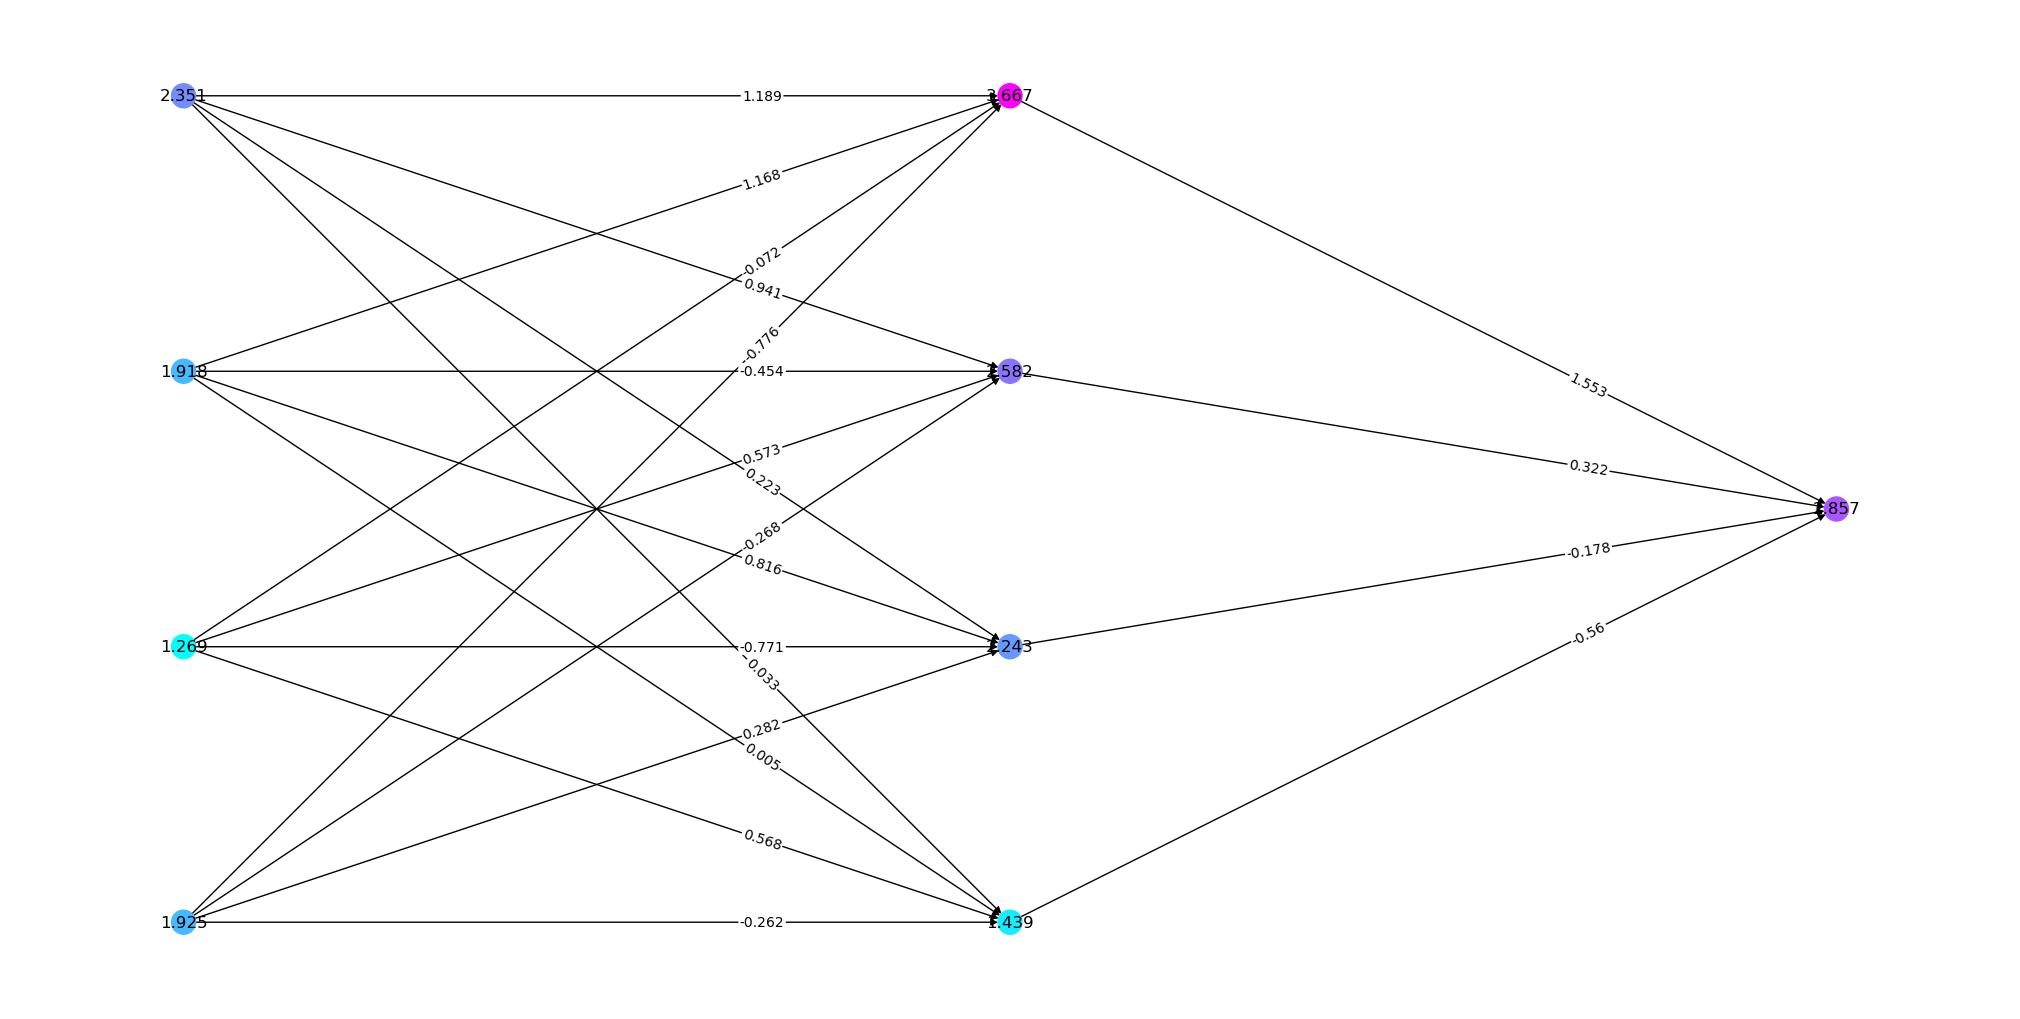

In [28]:
def plot_network(description):
    plt.figure(figsize=(20, 10))  # Set the size of the figure
    layers = description.split('Layer ')
    G = nx.DiGraph()
    importance = {}  # Dictionary to store the importance of each node
    edge_labels = {}  # Dictionary to store the edge labels
    for i in range(1, len(layers)):
        neurons = layers[i].split('Neuron ')
        for j in range(1, len(neurons)):
            node_name = f'L{i}N{j}'
            G.add_node(node_name, subset=i)
            # Compute the importance of the node as the sum of the absolute values of its parameters
            params = [float(param.split('=')[1].rstrip(')\n ')) for param in neurons[j].split('Param ')[1:]]
            importance[node_name] = round(sum(abs(param) for param in params), 3)
            if i > 1:
                for k in range(1, len(layers[i-1].split('Neuron '))):
                    edge = (f'L{i-1}N{k}', node_name)
                    G.add_edge(*edge)
                    # Add the weight of the edge as the label
                    edge_labels[edge] = round(params[k-1], 3)
    pos = nx.multipartite_layout(G)
    # Normalize the importance values to the range [0, 1] for coloring
    max_importance = max(importance.values())
    colors = [importance[node] / max_importance for node in G.nodes]
    nx.draw(G, pos, node_color=colors, with_labels=False, cmap=plt.cm.cool)
    nx.draw_networkx_labels(G, pos, labels=importance)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, 
                             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1'))
    plt.show()

plot_network(layers)

[0] loss: 0.0638
[0] loss: 0.0596
[1] loss: 0.0558
[2] loss: 0.0525


c:\Users\bovam\miniconda3\envs\aispace\Lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


[3] loss: 0.0496
[4] loss: 0.0469
[5] loss: 0.0445
[6] loss: 0.0423
[7] loss: 0.0404
[8] loss: 0.0386
[9] loss: 0.0369
[10] loss: 0.0354
[11] loss: 0.0340
[12] loss: 0.0327
[13] loss: 0.0315
[14] loss: 0.0303
[15] loss: 0.0293
[16] loss: 0.0283
[17] loss: 0.0274
[18] loss: 0.0265
[19] loss: 0.0257


[0] loss: 0.0249


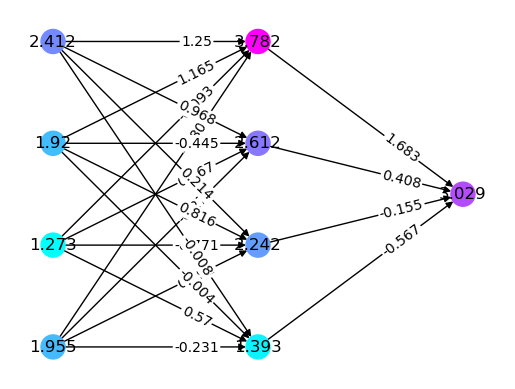

In [34]:
# Initialize figure
fig, ax = plt.subplots()

def plot_network(description, ax):
    ax.clear()  # Clear the current plot
    layers = description.split('Layer ')
    G = nx.DiGraph()
    importance = {}  # Dictionary to store the importance of each node
    edge_labels = {}  # Dictionary to store the edge labels
    for i in range(1, len(layers)):
        neurons = layers[i].split('Neuron ')
        for j in range(1, len(neurons)):
            node_name = f'L{i}N{j}'
            G.add_node(node_name, subset=i)
            # Compute the importance of the node as the sum of the absolute values of its parameters
            params = [float(param.split('=')[1].rstrip(')\n ')) for param in neurons[j].split('Param ')[1:]]
            importance[node_name] = round(sum(abs(param) for param in params), 3)
            if i > 1:
                for k in range(1, len(layers[i-1].split('Neuron '))):
                    edge = (f'L{i-1}N{k}', node_name)
                    G.add_edge(*edge)
                    # Add the weight of the edge as the label
                    edge_labels[edge] = round(params[k-1], 3)
    pos = nx.multipartite_layout(G)
    # Normalize the importance values to the range [0, 1] for coloring
    max_importance = max(importance.values())
    colors = [importance[node] / max_importance for node in G.nodes]
    nx.draw(G, pos, node_color=colors, with_labels=False, cmap=plt.cm.cool, ax=ax)
    nx.draw_networkx_labels(G, pos, labels=importance, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, 
                             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1'), ax=ax)

def update(k):
    # Forward pass
    ypred = [n(x) for x in xs] # predictions
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) # loss function (MSE)
    
    # Backward pass
    # zero out gradients (otherwise they accumulate)
    for p in n.parameters():
        p.grad = 0.0
    loss.backward() # backpropagate gradients

    # Update parameters
    lr = 0.05 # learning rate
    for p in n.parameters():
        p.data -= lr * p.grad # gradient descent

    print(f'[{k}] loss: {loss.data:.4f}')

    # Get the current state of the network
    description = n.describe()

    # Update the plot
    plot_network(description, ax)

# Create animation
ani = animation.FuncAnimation(fig, update, frames=range(20))

# Display the animation
HTML(ani.to_jshtml())